In [4]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

# Making results folder -- change to what this should actually be 
path = '/Users/xiaoqianxiao/projects/NARSAD'
os.chdir(path)

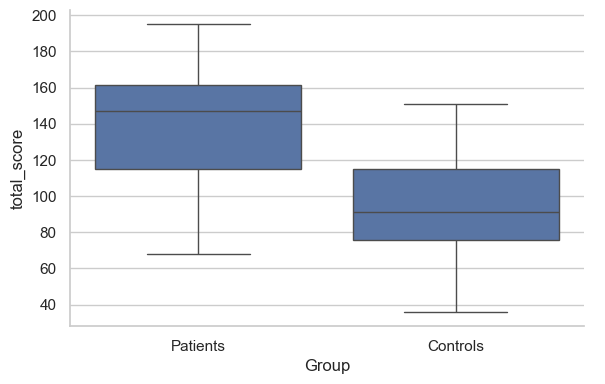

Mean and SEM for total_score:
Controls - Mean: 93.679, SEM: 3.777
Patients - Mean: 139.353, SEM: 4.318
T-test results for total_score:
T-statistic: 7.961, P-value: 0.000



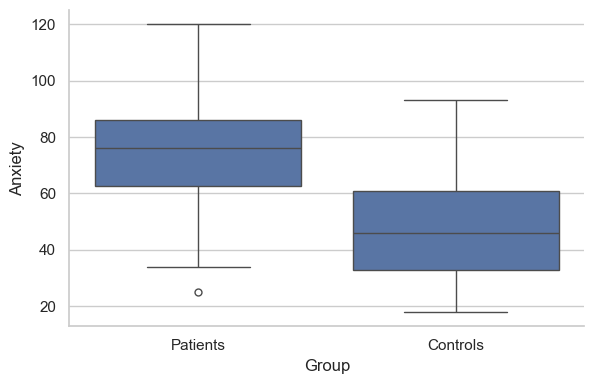

Mean and SEM for Anxiety:
Controls - Mean: 48.623, SEM: 2.588
Patients - Mean: 74.569, SEM: 2.704
T-test results for Anxiety:
T-statistic: 6.933, P-value: 0.000



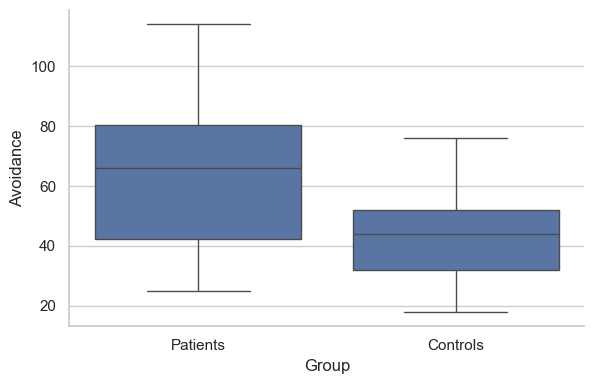

Mean and SEM for Avoidance:
Controls - Mean: 45.057, SEM: 2.256
Patients - Mean: 64.784, SEM: 3.235
T-test results for Avoidance:
T-statistic: 5.002, P-value: 0.000



In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Load the Excel sheet
ecr_data = pd.read_excel('/Users/xiaoqianxiao/projects/NARSAD/EDR/ECR.xlsx')

# Create a new column for the group based on subID
ecr_data['Group'] = ecr_data['subID'].apply(lambda x: 'Patients' if x.startswith('N1') else 'Controls')

# Set up the plotting environment
sns.set(style="whitegrid")

# Create a catplot for each variable
for variable in ['total_score', 'Anxiety', 'Avoidance']:
    g = sns.catplot(x='Group', y=variable, data=ecr_data, kind='box', height=4, aspect=1.5)
    g.set_axis_labels("Group", variable)
    g.set_titles(f"{variable} by Group")
    plt.show()

    # Calculate means and SEM
    mean_values = ecr_data.groupby('Group')[variable].mean()
    sem_values = ecr_data.groupby('Group')[variable].sem()

    # Print means and SEM
    print(f"Mean and SEM for {variable}:")
    for group in mean_values.index:
        print(f"{group} - Mean: {mean_values[group]:.3f}, SEM: {sem_values[group]:.3f}")

    # Perform t-test
    patients = ecr_data[ecr_data['Group'] == 'Patients'][variable]
    controls = ecr_data[ecr_data['Group'] == 'Controls'][variable]
    
    t_stat, p_value = stats.ttest_ind(patients, controls, equal_var=False)  # Welch's t-test

    print(f"T-test results for {variable}:")
    print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.3f}\n")

In [7]:
import pandas as pd
import numpy as np

# Parameters
trialnumber = range(1, 25)  # Can adjust to first half of trials: range(1, 13)
excludeparticipants = 1  # Set to 0 to include all participants
rejtrials_threshold = 24  # Adjust the threshold as needed

# Load the table
peakstatstable = pd.read_csv('/Users/xiaoqianxiao/projects/NARSAD/EDR/peak_stats_table-phase1.csv')

# Extract unique participant IDs and trial types
participants = peakstatstable['sid'].unique()
trial_types = peakstatstable['stTy'].unique()

# Group data by participant
participant_groups = peakstatstable.groupby('sid')
dat = []

for participant_id in participants:
    data = participant_groups.get_group(participant_id)
    subject_data = {'subID': participant_id}

    # Process data if there are 24 trials
    if len(data) == 24:
        phase1_data = data[data['stNum'].isin(trialnumber)]

        # Rejected trials (based on "Publication recommendations for electrodermal measurements")
        rejTrials = phase1_data[phase1_data['phaBase2Peak'] < 0].index
        phase1_data.loc[rejTrials, 'phaBase2Peak'] = 0  # Mark non-response trials as 0

        subject_data['rejTrials1'] = len(rejTrials)

        # Separate data by stim type
        stim_groups = phase1_data.groupby('stTy')

        try:
            # Calculate mean, SE, and count for CSS, CSR, and CS-
            css_data = stim_groups.get_group('CS+S')
            subject_data['meanCSS1'] = css_data['phaBase2Peak'].mean()
            subject_data['seCSS1'] = css_data['phaBase2Peak'].std() / np.sqrt(len(css_data))
            subject_data['nCSS1'] = len(css_data)

            csr_data = stim_groups.get_group('CS+R')
            subject_data['meanCSR1'] = csr_data['phaBase2Peak'].mean()
            subject_data['seCSR1'] = csr_data['phaBase2Peak'].std() / np.sqrt(len(css_data))
            subject_data['nCSR1'] = len(csr_data)

            csminus_data = stim_groups.get_group('CS-')
            subject_data['meanCSminus1'] = csminus_data['phaBase2Peak'].mean()
            subject_data['seCSminus1'] = csminus_data['phaBase2Peak'].std() / np.sqrt(len(css_data))
            subject_data['nCSminus1'] = len(csminus_data)

        except KeyError:
            print(f"Missing stim type data for participant {participant_id}")
        
    dat.append(subject_data)

# Convert to a DataFrame if you need a structured output
dat_df = pd.DataFrame(dat)
print(dat_df)

    subID  rejTrials1  meanCSS1    seCSS1  nCSS1  meanCSR1    seCSR1  nCSR1  \
0    N101           4  0.034000  0.020075      8  0.010125  0.007352      8   
1    N102           0  0.003625  0.001558      8  0.000875  0.000295      8   
2    N103           1  0.117500  0.020816      8  0.132125  0.025778      8   
3    N104           5  0.001625  0.000944      8  0.001125  0.000581      8   
4    N105           2  0.004625  0.001945      8  0.001625  0.000981      8   
..    ...         ...       ...       ...    ...       ...       ...    ...   
99   N255           6  0.001000  0.000681      8  0.001250  0.000750      8   
100  N257           4  0.031875  0.010315      8  0.041125  0.021445      8   
101  N258           0  0.034000  0.006980      8  0.029000  0.007533      8   
102  N259           2  0.015000  0.004706      8  0.020875  0.008941      8   
103  N260           1  0.081750  0.025366      8  0.068750  0.014820      8   

     meanCSminus1  seCSminus1  nCSminus1  
0       

In [10]:
import statsmodels.formula.api as smf
# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('/Users/xiaoqianxiao/projects/NARSAD/EDR/ECR.xlsx')
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['ECR_total'] = merged_data['total_score']  # Gender as categorical
merged_data['ECR_anxiety'] = merged_data['Anxiety']  # Drug as categorical
merged_data['ECR_avoidance'] = merged_data['Avoidance']  # Drug as categorical

# Reshape data to stack meanCSR1, meanCSS1, and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group', 'ECR_total','ECR_avoidance','ECR_anxiety'], 
                    value_vars=['meanCSR1', 'meanCSS1', 'meanCSminus1'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR1': 1, 
    'meanCSS1': 2, 
    'meanCSminus1': 3
})


# Model formula including main effect of stim_type
model_formula = 'response ~ patient_group + stim_type + ECR_avoidance'

# Fit the model
model = smf.ols(formula=model_formula, data=long_data).fit()

# Display the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     2.710
Date:                Tue, 04 Mar 2025   Prob (F-statistic):             0.0452
Time:                        12:20:57   Log-Likelihood:                 302.72
No. Observations:                 312   AIC:                            -597.4
Df Residuals:                     308   BIC:                            -582.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0869      0.019      4.587

/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_50581/275004491.py:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_data['stim_type'] = long_data['stim_type'].replace({


In [13]:
merged_data.head()

,subID,rejTrials1,meanCSS1,seCSS1,nCSS1,meanCSR1,seCSR1,nCSR1,meanCSminus1,seCSminus1,...,ecr_q36,demo_age,demo_sex_at_birth,Anxiety,Avoidance,total_score,patient_group,ECR_total,ECR_anxiety,ECR_avoidance
0,N101,4,0.034000,0.020075,8,0.010125,0.007352,8,0.007250,0.005437,...,3,21,1,71,66,137,1,137,71,66
1,N102,0,0.003625,0.001558,8,0.000875,0.000295,8,0.002250,0.000453,...,1,25,2,34,34,68,1,68,34,34
2,N103,1,0.117500,0.020816,8,0.132125,0.025778,8,0.128375,0.030689,...,2,23,1,60,39,99,1,99,60,39
3,N104,5,0.001625,0.000944,8,0.001125,0.000581,8,0.004875,0.002364,...,4,33,2,104,62,166,1,166,104,62
4,N105,2,0.004625,0.001945,8,0.001625,0.000981,8,0.004500,0.002163,...,2,21,1,62,45,107,1,107,62,45


In [11]:
long_data

,subID,patient_group,ECR_total,ECR_avoidance,ECR_anxiety,stim_type,response
0,N101,1,137,66,71,1,0.010125
1,N102,1,68,34,34,1,0.000875
2,N103,1,99,39,60,1,0.132125
3,N104,1,166,62,104,1,0.001125
4,N105,1,107,45,62,1,0.001625
...,...,...,...,...,...,...,...
307,N255,0,48,19,29,3,0.009500
308,N257,0,93,36,57,3,0.038125
309,N258,0,122,51,71,3,0.028250
310,N259,0,133,64,69,3,0.009500
